In [19]:
from random import shuffle
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
# from tensorflow.keras.callbacks import TensorBoard
# from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
from sklearn import preprocessing
import matplotlib.pyplot as plt
from collections import deque
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Preprocessing

In [2]:
bok = pd.read_csv('../../../data/bokhoven.csv')

In [3]:
bok.drop(['Unnamed: 0', 'datumBeginMeting'], axis=1, inplace=True) #don't need these

In [4]:
#transform to timestamp and add features
def AddColumns(df):
    df['Begin'] = pd.to_datetime(df['Begin'])
    #df['Date'] = pd.DatetimeIndex(df.Begin).normalize()
    df['Weekday'] = df['Begin'].dt.day_name()
    #df['Hour'] = df['Begin'].dt.hour
    df['TimeOfDay'] = df['Begin'].dt.time
    #df['Year'] = df['Begin'].dt.year
    df['Month'] = df['Begin'].dt.month_name()
    #df['Day'] = df['Begin'].dt.day
    return df

In [5]:
new_bok = AddColumns(bok)
new_bok[63:70]

,hstWaarde,Bokhoven,Begin,cumsum_previous_15,rain_-15_class,Weekday,TimeOfDay,Month
63,260.0,0.0,2018-01-03 15:00:00,0.0,0,Wednesday,15:00:00,January
64,0.0,0.0,2018-01-03 16:00:00,0.0,0,Wednesday,16:00:00,January
65,0.0,0.0,2018-01-03 17:00:00,0.0,0,Wednesday,17:00:00,January
66,250.0,0.0,2018-01-03 18:00:00,0.0,0,Wednesday,18:00:00,January
67,300.0,0.0,2018-01-03 19:00:00,0.0,0,Wednesday,19:00:00,January
68,0.0,0.0,2018-01-03 20:00:00,0.0,0,Wednesday,20:00:00,January
69,220.0,0.0,2018-01-03 21:00:00,0.0,0,Wednesday,21:00:00,January


In [6]:
def preprocess_df(df):
    for col in df.columns:  # go through all of the columns
        if col == "hstWaarde":  # normalize the flow column 
            df[col] = (df[col]-df[col].min())/(df[col].max()- df[col].min()) #scale between 0 and 1 using min-max normalization
    df.dropna(inplace=True)  # cleanup again... jic. Those nasty NaNs love to creep in.
    return df

In [7]:
#extract dry days
cleaned_data = new_bok[new_bok['rain_-15_class'] == 0]
preproc = preprocess_df(cleaned_data)

C:\Users\20174994\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\20174994\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
#renew indices
preproc_dry = preproc.reset_index(inplace=False)
preproc_dry.drop(['index','Bokhoven', 'cumsum_previous_15', 'rain_-15_class'], axis = 1, inplace=True)

C:\Users\20174994\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


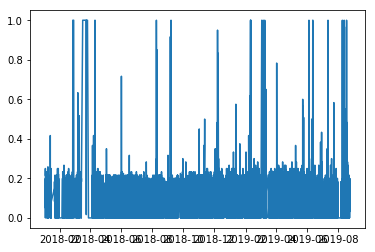

In [9]:
#check normalization results
plt.plot(preproc_dry['Begin'], preproc_dry['hstWaarde']);

In [10]:
#create and concat dummies
dummies = pd.get_dummies(preproc_dry[['Weekday','TimeOfDay','Month']])
preproc_dry.drop(['Weekday','TimeOfDay','Month'], axis = 1, inplace=True)
main_df = pd.concat([preproc_dry, dummies], axis = 1)
main_df.drop('Begin', axis=1, inplace=True)

In [11]:
#split the data is 60% training, 20% validation and 20% test data
train = main_df.iloc[:-int(0.4*len(main_df))]

rest = main_df[main_df.index >= max(train.index)]
rest = rest.reset_index()
rest = rest.drop('index', axis = 1)

test = rest[rest.index >= len(rest)//2]
test = test.reset_index()
test = test.drop('index', axis = 1)

validation = rest[rest.index < len(rest)//2]
validation = validation.reset_index()
validation = validation.drop('index', axis = 1)

In [12]:
train.shape, test.shape, validation.shape

((5611, 44), (1871, 44), (1870, 44))

In [13]:
#make sure to only predict using past data
SEQ_LEN = 168  # how long of a preceeding sequence to collect for RNN (168 hours = 1 week)
FUTURE_PERIOD_PREDICT = 24 #how far to predict ahead of time



def sequential(df):
    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
    for i in df.values:  # iterate over the values
        prev_days.append([n for n in i[1:]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we use the past week
            sequential_data.append([np.array(prev_days), i[0]])  # append those bad boys!
    shuffle(sequential_data)
    
    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets -> flow to be predicted

    return np.array(X), np.array(y)  # return X and y...and make X a numpy array!

In [14]:
train_x, train_y = sequential(train)
validation_x, validation_y = sequential(validation)

In [15]:
train_x.shape, train_y.shape

((5444, 168, 43), (5444,))

# Model Building

In [17]:
EPOCHS = 10  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='relu'))


opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy', 'mae']
)

early_stopping_monitor = EarlyStopping(patience = 3)

# tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

# filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
# checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y)#,
#     callbacks=[tensorboard, checkpoint],
)

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model
# model.save("models/{}".format(NAME))

Train on 5444 samples, validate on 1703 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
5444/5444 [==============================] - 86s 16ms/sample - loss: 0.4689 - acc: 0.4791 - mean_absolute_error: 0.5824 - val_loss: 0.5444 - val_acc: 0.4474 - val_mean_absolute_error: 0.1352
Epoch 2/10
5444/5444 [==============================] - 85s 16ms/sample - loss: 0.3322 - acc: 0.4774 - mean_absolute_error: 0.6166 - val_loss: 0.5173 - val_acc: 0.4474 - val_mean_absolute_error: 0.1837
Epoch 3/10
5444/5444 [==============================] - 85s 16ms/sample - loss: 0.3112 - acc: 0.4774 - mean_absolute_error: 0.7065 - val_loss: 0.6520 - val_acc: 0.4474 - val_mean_absolute_error: 0.1447
Epoch 4/10
5444/5444 [==============================] - 89s 16ms/sample - loss: 0.3160 - acc: 0.4776 - mean_absolute_error: 0.6507 - val_loss: 0.6476 - val_acc: 0.4474 - val_mean_absolute_error: 0.1576
Epoch 5/10
5444/5444 [============================

In [20]:
EPOCHS = 1  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='relu'))


opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['accuracy', 'mae']
)

early_stopping_monitor = EarlyStopping(patience = 3)

# tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

# filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
# checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y)#,
#     callbacks=[tensorboard, checkpoint],
)

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model
# model.save("models/{}".format(NAME))

Train on 5444 samples, validate on 1703 samples
5444/5444 [==============================] - 88s 16ms/sample - loss: 0.2362 - acc: 0.8573 - mean_absolute_error: 0.2362 - val_loss: 0.1159 - val_acc: 1.0000 - val_mean_absolute_error: 0.1159
Test loss: 0.11592092617899967
Test accuracy: 1.0
